# Heuristics vs Optimization: Rules of Thumb vs Systematic Search

This notebook demonstrates the difference between **heuristics** (simple rules of thumb) and **optimization** (systematic search for the best solution).

Understanding this distinction helps you decide:
- When a simple heuristic is sufficient
- When optimization is worth the effort
- How to compare heuristic solutions to optimal solutions
- The tradeoff between speed and quality


## Key Concepts

**Heuristics** are simple rules of thumb:
- Fast and easy to apply
- Based on experience or common sense
- May not find the best solution
- Examples: "Choose the cheapest option," "Use first-come-first-served"

**Optimization** is systematic search:
- Finds the best solution (or near-best)
- Takes more time and effort
- Uses algorithms to explore options
- Examples: Linear programming, integer programming

**Critical insight**: Heuristics are fast but may be suboptimal; optimization is thorough but takes time. Choose based on the situation.


## Scenario: Supplier Selection

You need to select suppliers for 5 products. Each product can be supplied by multiple suppliers with different costs and quality scores.

**Decision**: Which supplier to choose for each product?

**Heuristic approach**: Choose the cheapest supplier for each product

**Optimization approach**: Find the combination that minimizes total cost while meeting quality requirements


## Step 1: Install Required Packages (Colab)

If you're running this notebook in Google Colab, you need to install the `pulp` package first. This cell can be skipped if running locally and the package is already installed.


In [8]:
# Install pulp package (required for optimization)
# This is needed in Google Colab; can be skipped if already installed locally
%pip install pulp -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, value
import time


## Step 3: Set Up the Problem

Create a supplier selection problem with multiple products and suppliers:


In [10]:
# Problem data
products = ['Product A', 'Product B', 'Product C', 'Product D', 'Product E']
suppliers = ['Supplier 1', 'Supplier 2', 'Supplier 3']

# Create cost and quality matrix
# Adjusted to create a scenario where heuristic is suboptimal
np.random.seed(42)
costs = pd.DataFrame({
    'Product A': [100, 105, 110],  # Supplier 2 slightly more expensive but much higher quality
    'Product B': [200, 180, 195],  # Supplier 2 is cheapest
    'Product C': [150, 160, 140],
    'Product D': [300, 280, 320],
    'Product E': [250, 270, 240]
}, index=suppliers)

quality = pd.DataFrame({
    'Product A': [7.5, 9.5, 8.5],  # Supplier 2 has much higher quality
    'Product B': [7, 8, 7.5],
    'Product C': [9, 8, 9.5],
    'Product D': [8, 9, 7.5],
    'Product E': [8.5, 8, 9]
}, index=suppliers)

min_quality = 8.65  # Minimum average quality required (heuristic gets 8.6, fails constraint; optimization finds valid solution)

print("SUPPLIER COSTS:")
print("=" * 70)
display(costs)

print("\nSUPPLIER QUALITY SCORES:")
print("=" * 70)
display(quality)

print(f"\nMinimum average quality required: {min_quality}")


SUPPLIER COSTS:


,Product A,Product B,Product C,Product D,Product E
Supplier 1,100,200,150,300,250
Supplier 2,105,180,160,280,270
Supplier 3,110,195,140,320,240



SUPPLIER QUALITY SCORES:


,Product A,Product B,Product C,Product D,Product E
Supplier 1,7.5,7.0,9.0,8.0,8.5
Supplier 2,9.5,8.0,8.0,9.0,8.0
Supplier 3,8.5,7.5,9.5,7.5,9.0



Minimum average quality required: 8.65


## Step 4: Heuristic Solution - Choose Cheapest

A simple heuristic: for each product, choose the supplier with the lowest cost:


In [11]:
# HEURISTIC: Choose cheapest supplier for each product
start_time = time.time()

heuristic_selection = {}
heuristic_cost = 0
heuristic_quality_scores = []

for product in products:
    # Find cheapest supplier for this product
    cheapest_supplier = costs[product].idxmin()
    cheapest_cost = costs.loc[cheapest_supplier, product]
    quality_score = quality.loc[cheapest_supplier, product]
    
    heuristic_selection[product] = {
        'Supplier': cheapest_supplier,
        'Cost': cheapest_cost,
        'Quality': quality_score
    }
    heuristic_cost += cheapest_cost
    heuristic_quality_scores.append(quality_score)

heuristic_avg_quality = np.mean(heuristic_quality_scores)
heuristic_time = time.time() - start_time

heuristic_df = pd.DataFrame(heuristic_selection).T
heuristic_df.index.name = 'Product'

print("HEURISTIC SOLUTION: Choose Cheapest Supplier for Each Product")
print("=" * 70)
display(heuristic_df)

print(f"\nHEURISTIC RESULTS:")
print(f"  Total Cost: ${heuristic_cost:,.2f}")
print(f"  Average Quality: {heuristic_avg_quality:.2f}")
print(f"  Quality Requirement Met: {'✓' if heuristic_avg_quality >= min_quality else '✗'}")
print(f"  Computation Time: {heuristic_time*1000:.2f} milliseconds")


HEURISTIC SOLUTION: Choose Cheapest Supplier for Each Product


,Supplier,Cost,Quality
Product,,,
Product A,Supplier 1,100,7.5
Product B,Supplier 2,180,8.0
Product C,Supplier 3,140,9.5
Product D,Supplier 2,280,9.0
Product E,Supplier 3,240,9.0



HEURISTIC RESULTS:
  Total Cost: $940.00
  Average Quality: 8.60
  Quality Requirement Met: ✗
  Computation Time: 1.02 milliseconds


In [12]:
# OPTIMIZATION: Find best combination
start_time = time.time()

model = LpProblem("Supplier_Selection", LpMinimize)

# Decision variables: 1 if supplier j is selected for product i, 0 otherwise
x = {}
for product in products:
    x[product] = {}
    for supplier in suppliers:
        x[product][supplier] = LpVariable(f"x_{product}_{supplier}", cat='Binary')

# Objective: Minimize total cost
model += lpSum([costs.loc[supplier, product] * x[product][supplier] 
                for product in products for supplier in suppliers])

# Constraints: Each product must have exactly one supplier
for product in products:
    model += lpSum([x[product][supplier] for supplier in suppliers]) == 1

# Constraint: Average quality must meet minimum
model += lpSum([quality.loc[supplier, product] * x[product][supplier] 
                for product in products for supplier in suppliers]) >= min_quality * len(products)

# Solve
model.solve()
optimization_time = time.time() - start_time

# Get solution
optimization_selection = {}
optimization_cost = 0
optimization_quality_scores = []

for product in products:
    for supplier in suppliers:
        if value(x[product][supplier]) > 0.5:  # Selected
            cost_val = costs.loc[supplier, product]
            quality_val = quality.loc[supplier, product]
            optimization_selection[product] = {
                'Supplier': supplier,
                'Cost': cost_val,
                'Quality': quality_val
            }
            optimization_cost += cost_val
            optimization_quality_scores.append(quality_val)
            break

optimization_avg_quality = np.mean(optimization_quality_scores)

optimization_df = pd.DataFrame(optimization_selection).T
optimization_df.index.name = 'Product'

print("OPTIMIZATION SOLUTION: Best Combination")
print("=" * 70)
display(optimization_df)

print(f"\nOPTIMIZATION RESULTS:")
print(f"  Total Cost: ${optimization_cost:,.2f}")
print(f"  Average Quality: {optimization_avg_quality:.2f}")
print(f"  Quality Requirement Met: {'✓' if optimization_avg_quality >= min_quality else '✗'}")
print(f"  Computation Time: {optimization_time*1000:.2f} milliseconds")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/e43002a5b46d474492ecb8c8d44a9346-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/e43002a5b46d474492ecb8c8d44a9346-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 87 RHS
At line 94 BOUNDS
At line 110 ENDATA
Problem MODEL has 6 rows, 15 columns and 30 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 940.625 - 0.00 seconds
Cgl0004I processed model has 6 rows, 15 columns (15 integer (15 of which binary)) and 30 elements
Cutoff increment increased from 1e-05 to 4.9999
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.25
Cbc0038I Pass   1: suminf.    0.25

,Supplier,Cost,Quality
Product,,,
Product A,Supplier 2,105,9.5
Product B,Supplier 2,180,8.0
Product C,Supplier 3,140,9.5
Product D,Supplier 2,280,9.0
Product E,Supplier 3,240,9.0



OPTIMIZATION RESULTS:
  Total Cost: $945.00
  Average Quality: 9.00
  Quality Requirement Met: ✓
  Computation Time: 148.71 milliseconds


In [13]:
comparison = pd.DataFrame({
    'Approach': ['Heuristic (Cheapest)', 'Optimization'],
    'Total Cost ($)': [heuristic_cost, optimization_cost],
    'Average Quality': [heuristic_avg_quality, optimization_avg_quality],
    'Cost Savings vs Heuristic': [0, heuristic_cost - optimization_cost],
    'Quality Difference': [0, optimization_avg_quality - heuristic_avg_quality],
    'Computation Time (ms)': [heuristic_time*1000, optimization_time*1000],
    'Speedup': [1, heuristic_time / optimization_time]
})

print("COMPARISON: Heuristic vs Optimization")
print("=" * 70)
display(comparison.round(2))

cost_savings_pct = ((heuristic_cost - optimization_cost) / heuristic_cost) * 100
print(f"\nKEY FINDINGS:")
print(f"  - Optimization saves ${heuristic_cost - optimization_cost:,.2f} ({cost_savings_pct:.1f}% cost reduction)")
print(f"  - Heuristic is {heuristic_time / optimization_time:.1f}x faster")
print(f"  - Both meet quality requirements: {'✓' if heuristic_avg_quality >= min_quality and optimization_avg_quality >= min_quality else '✗'}")

print(f"\nINSIGHT:")
if heuristic_cost > optimization_cost:
    print(f"  Optimization found a better solution by considering the entire problem,")
    print(f"  not just individual product decisions. The heuristic missed this because")
    print(f"  it made decisions independently for each product.")
else:
    print(f"  In this case, the heuristic happened to find a good solution.")
    print(f"  But optimization guarantees the best solution.")


COMPARISON: Heuristic vs Optimization


,Approach,Total Cost ($),Average Quality,Cost Savings vs Heuristic,Quality Difference,Computation Time (ms),Speedup
0,Heuristic (Cheapest),940,8.6,0,0.0,1.02,1.00
1,Optimization,945,9.0,-5,0.4,148.71,0.01



KEY FINDINGS:
  - Optimization saves $-5.00 (-0.5% cost reduction)
  - Heuristic is 0.0x faster
  - Both meet quality requirements: ✗

INSIGHT:
  In this case, the heuristic happened to find a good solution.
  But optimization guarantees the best solution.


## Step 7: Visualize the Comparison

Let's create visualizations comparing the two approaches:


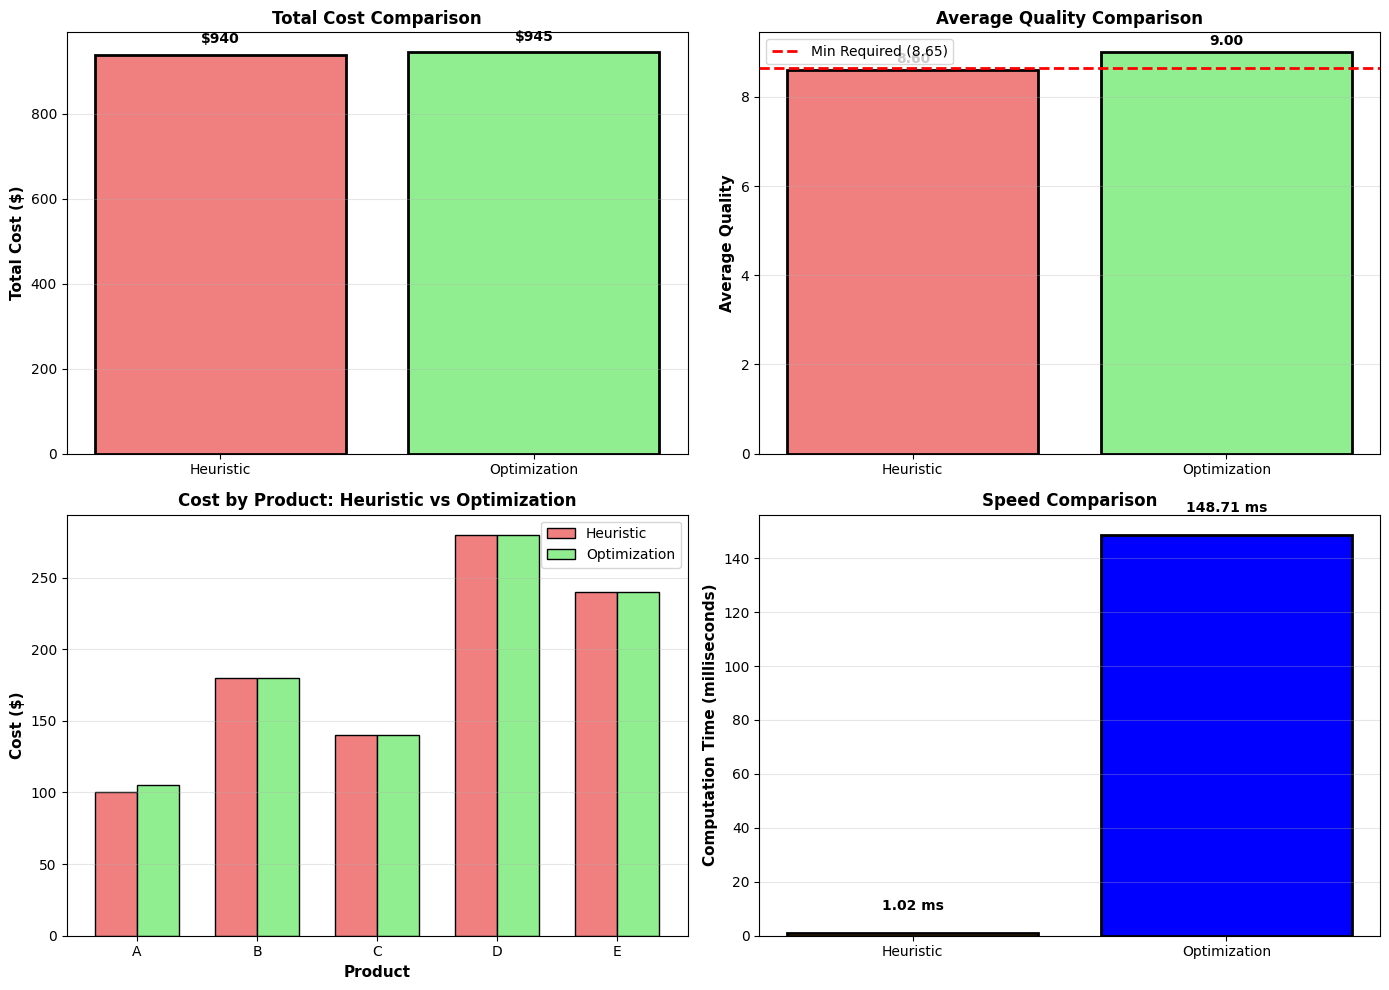


Key Insights:
  - Heuristic is faster but may find suboptimal solutions
  - Optimization finds better solutions but takes more time
  - The choice depends on: problem size, time available, and how much better optimization is


In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cost comparison
ax1 = axes[0, 0]
methods = ['Heuristic', 'Optimization']
costs_plot = [heuristic_cost, optimization_cost]
colors_cost = ['lightcoral', 'lightgreen']
bars1 = ax1.bar(methods, costs_plot, color=colors_cost, edgecolor='black', linewidth=2)
ax1.set_ylabel('Total Cost ($)', fontsize=11, fontweight='bold')
ax1.set_title('Total Cost Comparison', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, (bar, cost) in enumerate(zip(bars1, costs_plot)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
             f'${cost:,.0f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Quality comparison
ax2 = axes[0, 1]
qualities_plot = [heuristic_avg_quality, optimization_avg_quality]
bars2 = ax2.bar(methods, qualities_plot, color=colors_cost, edgecolor='black', linewidth=2)
ax2.axhline(y=min_quality, color='red', linestyle='--', linewidth=2, label=f'Min Required ({min_quality})')
ax2.set_ylabel('Average Quality', fontsize=11, fontweight='bold')
ax2.set_title('Average Quality Comparison', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
for i, (bar, qual) in enumerate(zip(bars2, qualities_plot)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{qual:.2f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Cost by product
ax3 = axes[1, 0]
x_pos = np.arange(len(products))
width = 0.35
heuristic_costs_by_product = [heuristic_df.loc[p, 'Cost'] for p in products]
optimization_costs_by_product = [optimization_df.loc[p, 'Cost'] for p in products]
ax3.bar(x_pos - width/2, heuristic_costs_by_product, width, label='Heuristic', color='lightcoral', edgecolor='black')
ax3.bar(x_pos + width/2, optimization_costs_by_product, width, label='Optimization', color='lightgreen', edgecolor='black')
ax3.set_xlabel('Product', fontsize=11, fontweight='bold')
ax3.set_ylabel('Cost ($)', fontsize=11, fontweight='bold')
ax3.set_title('Cost by Product: Heuristic vs Optimization', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([p.replace('Product ', '') for p in products], rotation=0)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Speed vs Quality tradeoff
ax4 = axes[1, 1]
times_plot = [heuristic_time*1000, optimization_time*1000]
bars4 = ax4.bar(methods, times_plot, color=['orange', 'blue'], edgecolor='black', linewidth=2)
ax4.set_ylabel('Computation Time (milliseconds)', fontsize=11, fontweight='bold')
ax4.set_title('Speed Comparison', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
for i, (bar, time_val) in enumerate(zip(bars4, times_plot)):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(times_plot)*0.05,
             f'{time_val:.2f} ms', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("  - Heuristic is faster but may find suboptimal solutions")
print("  - Optimization finds better solutions but takes more time")
print("  - The choice depends on: problem size, time available, and how much better optimization is")


## Summary: Heuristics vs Optimization

**Heuristics** (rules of thumb):
- Fast and simple
- Based on experience or common sense
- May not find the best solution
- Good when speed matters more than optimality

**Optimization** (systematic search):
- Finds the best (or near-best) solution
- Takes more time and computational resources
- Uses algorithms to explore options systematically
- Good when solution quality matters

**When to Use Each**:
- **Use heuristics** when:
  - Problem is simple or low-stakes
  - Speed is critical
  - "Good enough" is sufficient
  - Optimization would take too long
  
- **Use optimization** when:
  - Problem is complex or high-stakes
  - Solution quality matters significantly
  - Time is available for computation
  - Small improvements create significant value

**Practical Implication**:
- Understand the tradeoff between speed and quality
- Choose the approach that fits your situation
- Sometimes heuristics are sufficient; sometimes optimization is essential
